In [10]:
import pandas as pd

df = pd.read_csv("../data/merge_data_3.csv",encoding = "cp949")
df

,base_dt,dow,ccw_nm,adng_nm,cell_id,cell_xcrd,cell_ycrd,gender,age,app_web,time_zone,count_cust_resident,count_cust_ra,count_cust_activity
0,20220605,7,용인시,동백1동,86135034,127.152250,37.286300,MALE,6,EV라운지,5,3.522,NaN,NaN
1,20220625,6,용인시,상현2동,84375196,127.090080,37.309536,MALE,8,파워큐브차저,2,4.231,NaN,NaN
2,20220614,2,용인시,포곡읍,87958893,127.216600,37.274303,FEMALE,14,EV라운지,1,18.440,NaN,NaN
3,20220619,7,용인시,신봉동,84119243,127.080970,37.323480,MALE,13,EV라운지,2,4.335,4.335,4.335
4,20220624,5,용인시,상현2동,84423187,127.091780,37.306840,MALE,8,EV라운지,4,4.231,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554239,20220611,6,성남시,시흥동,84519415,127.094604,37.412310,MALE,9,하이차저,1,NaN,4.173,NaN
554240,20220602,4,광주시,경안동,89239106,127.261300,37.406456,FEMALE,10,EV라운지,4,NaN,3.719,NaN
554241,20220620,1,화성시,남양읍,76983320,126.830760,37.156020,MALE,11,하이차저,4,NaN,13.521,NaN
554242,20220607,2,성남시,위례동,85863462,127.141785,37.471504,MALE,10,EV라운지,4,NaN,11.457,NaN


In [11]:
## 가장 많이 나오는 동네 확인
df.adng_nm.value_counts()

서농동     19491
죽전1동    19422
역삼동     19264
모현읍     18914
구갈동     18769
        ...  
선부3동        1
박달1동        1
월곡1동        1
파평면         1
백석1동        1
Name: adng_nm, Length: 974, dtype: int64

In [38]:
## 서농동 데이터로 mclp 테스트 진행
test_df = df.loc[df.adng_nm == "서농동"][:500]
test_df

,base_dt,dow,ccw_nm,adng_nm,cell_id,cell_xcrd,cell_ycrd,gender,age,app_web,time_zone,count_cust_resident,count_cust_ra,count_cust_activity
96,20220602,4,용인시,서농동,83767089,127.069010,37.244110,MALE,9,EV라운지,3,5.128,5.128,5.128
127,20220629,3,용인시,서농동,83767070,127.069060,37.235550,FEMALE,12,EV라운지,1,15.290,15.290,15.290
252,20220620,1,용인시,서농동,83943064,127.075250,37.237823,MALE,14,EV라운지,4,3.150,NaN,NaN
256,20220603,5,용인시,서농동,83735085,127.067894,37.241400,MALE,10,EV라운지,4,10.992,NaN,NaN
285,20220606,1,용인시,서농동,83767070,127.069060,37.235550,FEMALE,12,EV라운지,6,6.116,6.116,6.116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29509,20220628,2,용인시,서농동,83943044,127.075294,37.228810,MALE,9,EV라운지,4,5.128,5.128,14.699
29732,20220626,7,용인시,서농동,83879075,127.072975,37.240970,MALE,8,EV라운지,6,5.128,NaN,NaN
29771,20220622,3,용인시,서농동,83847084,127.071830,37.244120,MALE,12,EV라운지,3,7.096,3.548,3.548
29823,20220622,3,용인시,서농동,83847056,127.071900,37.231503,MALE,7,EV라운지,2,7.485,NaN,16.785


## MCLP
https://github.com/cyang-kth/maximum-coverage-location

In [17]:
## 필요 패키지 로드
import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random

In [18]:
## 함수 정의
## 후보지 생성 함수
## 주어진 포인트(좌표)를 외곽으로 내부에 랜덤 후보지 생성
def generate_candidate_sites(points,M=100):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        points: a Numpy array with shape of (N,2)
        M: 생성할 random 좌표 수 (전기차 충전소 후보지 수)
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    hull = ConvexHull(points)                                   # points 좌표들의 외곽선 생성
    polygon_points = points[hull.vertices]                      # 외곽선을 구성하는 직선 간 점(좌표) 반환
    poly = Polygon(polygon_points)                              # 외곽선 모양의 도형 생성
    min_x, min_y, max_x, max_y = poly.bounds                    # 도형의 x축과 y축 좌표 최소,최대
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x), # x축 범위 내 random한 값
                             random.uniform(min_y, max_y)]) # y축 범위 내 random한 값
        if (random_point.within(poly)): # random한 좌표가 도형 안에 있다면 sites에 추가
            sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])

In [27]:
## MCLP 정의
def mclp(points,K,radius,M):
    """
    Solve maximum covering location problem
    Input:
        points: 데이터 좌표, 수요지점 수
        K: 설치할 전기차 충전소 수
        radius: 반경
        M: the number of candidate sites, which will randomly generated inside
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    sites = generate_candidate_sites(points,M)
    J = sites.shape[0] # 입지후보지 수
    I = points.shape[0] # 수요지점 수
    D = distance_matrix(points,sites) # 입지후보지와 수요지점 간 거리 계산
    mask1 = D<=radius
    D[mask1]=1 # 수요지점별로 입지후보지의 반경 내 속하면 1, 아니면 0
    D[~mask1]=0
    # Build model
    m = Model()
    # Add variables
    x = {}
    y = {}
    for i in range(I):
      y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i) # 모델에 수요지점 변수 추가 (변수 유형은 BINARY. 위치별 인수, 변수 이름 y+숫자)
    for j in range(J):
      x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j) # 입지후보지 변수 추가

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)# 입지후보지 제약 조건 (K개)

    for i in range(I): # 수요지점 제약 조건
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i]for i in range(I)),GRB.MAXIMIZE) # 목적함수 (제약 조건 포함. 모든 수요지점 더하기)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
               solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

In [28]:
## 시각화
def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

In [40]:
## 데이터 좌표값 가져오기

X = list(test_df["cell_xcrd"])
Y = list(test_df["cell_ycrd"])

points = np.array([list(i) for i in zip(X, Y)])
print(points.shape)
points

(500, 2)


array([[127.06901 ,  37.24411 ],
       [127.06906 ,  37.23555 ],
       [127.07525 ,  37.237823],
       [127.067894,  37.2414  ],
       [127.06906 ,  37.23555 ],
       [127.07069 ,  37.246372],
       [127.06901 ,  37.24411 ],
       [127.07689 ,  37.24594 ],
       [127.075294,  37.22881 ],
       [127.08941 ,  37.225254],
       [127.070694,  37.245018],
       [127.07521 ,  37.244133],
       [127.06901 ,  37.245014],
       [127.070206,  37.231495],
       [127.0798  ,  37.22973 ],
       [127.07469 ,  37.23557 ],
       [127.074646,  37.244583],
       [127.075294,  37.22926 ],
       [127.06791 ,  37.2396  ],
       [127.07238 ,  37.245926],
       [127.06734 ,  37.2414  ],
       [127.067894,  37.2414  ],
       [127.08941 ,  37.225254],
       [127.08376 ,  37.226585],
       [127.07239 ,  37.245476],
       [127.0707  ,  37.244568],
       [127.0685  ,  37.235096],
       [127.07183 ,  37.24412 ],
       [127.075294,  37.22881 ],
       [127.0713  ,  37.238262],
       [12

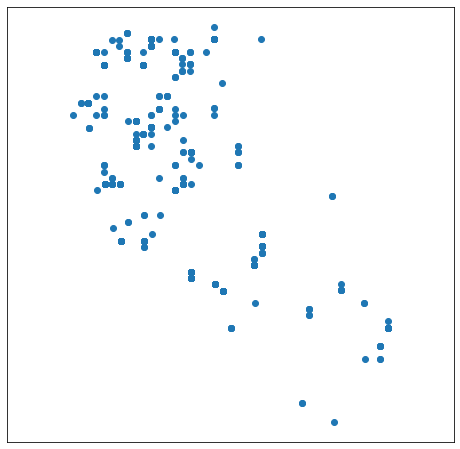

In [41]:
# Plot input data
plot_input(points)

In [42]:
# MCLP 구현
opts_sites, mobjVal = mclp(points, 3, 0.0028, 100)
opts_sites

----- Configurations -----
  Number of points 500
  K 3
  Radius 0.0028
  M 100
----- Output -----
  Running time : 0.022907257080078125 seconds
  Optimal coverage points: 249


array([[127.0773651 ,  37.22925078],
       [127.07289814,  37.24434573],
       [127.07343235,  37.23905106]])

In [45]:
## 최적 입지 선정
result = pd.DataFrame(opts_sites, columns=['경도','위도'])
result

,경도,위도
0,127.077365,37.229251
1,127.072898,37.244346
2,127.073432,37.239051


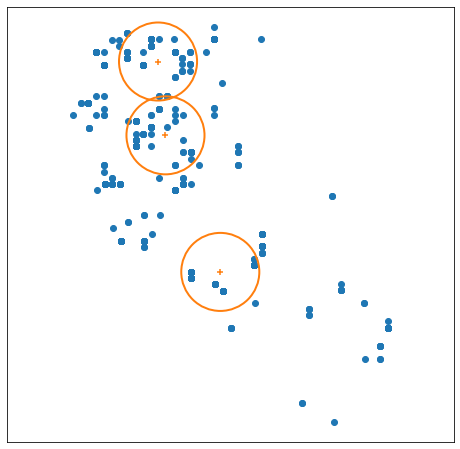

In [44]:
## 최적 입지 보여주기
plot_result(points, opts_sites, 0.0028)